In [37]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False




===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [3]:
ana[0].grl.events.sum() / (0.001 * 86400 * ana[0].grl.livetime.sum())

4.607932049722196

In [4]:
grl = ana[0].grl[ana[0].grl.livetime > 0.3]
rates = grl.events / (0.001 * 86400. * grl.livetime)
np.percentile(rates, 50), np.percentile(rates, 84), np.percentile(rates, 16)

(4.6150075768869705, 5.034446670943363, 4.199894397047974)

In [5]:
def get_event_rate_plot(grl, bin_width=7., **kwargs):
    """
    Plot TS distribution(s) and produce one plot
    
    Parameters
    ----------
    grl : csky.utils.Arrays
        e.g.: ana[0].grl
    
    bin_width : float
        interval length in days
        
    Returns
    -------
    N/A
    
    See also
    -------
    N/A
    """
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
        
    rates = grl.events / (0.001 * 86400. * grl.livetime)
    mjds = (grl.start + grl.stop) / 2
    h = hl.hist((mjds, rates), 
            bins=(np.r_[grl.start[0]:grl.stop[-1]+bin_width:bin_width], 100), 
            range=((56000,59040), (1,8)))
    h = h
    h = h.normalize(1).to_finite()
    h = h.contain_project(1, .5)
    hl.plot1d(ax, h, errorbands=True, drawstyle='default', color='#004466', label="IC86")
    ax.hlines(y=np.nanmean(h.values),  xmin=grl.start[0], xmax=grl.stop[-1], color='#d06050', label="Mean rate")
    
    ax.set_xlim(grl.start[0], grl.stop[-1])
    ax.set_ylim(3.2, 6.0)
    ax.set_ylabel('Rate (mHz)', fontsize = 20)
    ax.set_xlabel('Time (MJD)', fontsize = 20)
    ax.legend(loc=2, fontsize=14, frameon=True)
    return rates, h

In [6]:
ana[0].grl[ana[0].grl.livetime > 0.3]

Arrays(7948 items | columns: events, livetime, run, start, stop)

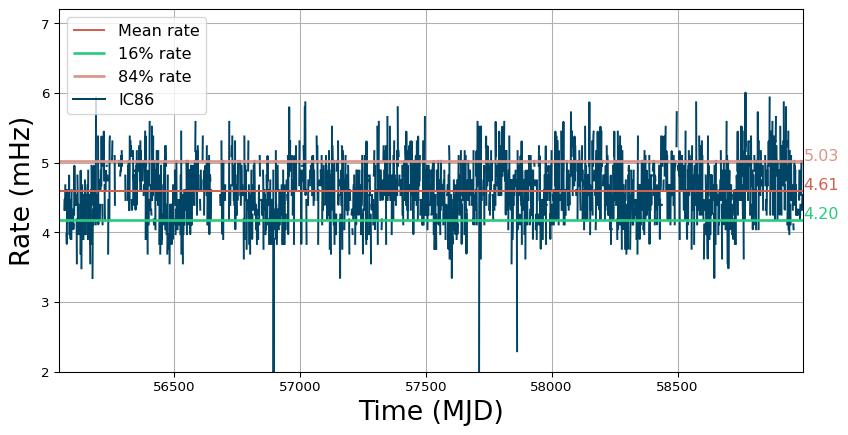

In [7]:
fig, ax = plt.subplots(figsize=(10,5), dpi=96)
rates, h = get_event_rate_plot(ana[0].grl[ana[0].grl.livetime > 0.3][0:7984:4], bin_width=1., ax=ax)
ax.set_ylim(2, 7.2)
ax.hlines(y=np.percentile(rates, 16),  xmin=56000, xmax=60000, color='#2aca80', label="16% rate", linewidth=2)
ax.hlines(y=np.percentile(rates, 84),  xmin=56000, xmax=60000, color='#dd9388', label="84% rate", linewidth=2)
ax.legend(loc=2, fontsize=12, frameon=True)
ax.text(x=59000,y=4.61, s="4.61",color='#d06050', fontsize = 12)
ax.text(x=59000,y=4.20, s="4.20",color='#2aca80', fontsize = 12)
ax.text(x=59000,y=5.03, s="5.03",color='#dd9388', fontsize = 12)
ax.grid()

In [8]:
grl_high = grl[(grl['events'] / (grl['livetime'] * 86400)) > 0.00503]
grl_low = grl[(grl['events'] / (grl['livetime'] * 86400)) < 0.00420]

# Simulate high/low rate
see `../script/06_do_signal_injection_high_low_rate.py`


# Seasonal Variation Results

In [110]:
### testing on jupyter ###
class args:
    # grb_name = "GRB180423A"    # real healpix example
    # grb_name = "GRB190415A"    # fake healpix example   
    def __init__(self, 
                 grb_name="GRB180423A", 
                 tw_in_second=10, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs
##########################
def get_tr(info):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    #### used for basic trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'prior', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(2.5),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
    }
    cy.CONF.update(conf)
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    tr = cy.get_trial_runner(ana=ana, src=src)
    return tr
##########################################################
def get_sens_disc(info, sigma=5, fit=True, variation=None, use_first=None):
    if variation is None:
        variation = ""
    elif variation == "high":
        variation = "/high"
    elif variation == "low":
        variation = "/low"
    else:
        raise("This variation is not implemented.")
    
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    
    #### used for spatial_prior_trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'ps', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(2.5),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
        }
    cy.CONF.update(conf)
    
    bg_files = glob(ANA_DIR+f"/allsky_scan/with_prior_background{variation}/tw{args.tw_in_second}/{args.grb_name}*.npz")
    try:
        if use_first is None:
            bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files]))
        else:
            bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files])[:use_first])
    except:
        raise(bg_files)
    
    n_injs = args.n_injs
    sig = {}
    for n_inj in n_injs:
        sig_files = glob(ANA_DIR+"/prior_injection{}/tw{}/{}/{}*{}.npy".format(
            variation,
            args.tw_in_second, 
            args.grb_name, 
            args.grb_name,
            n_inj))
        sig[n_inj] = cy.utils.Arrays(np.ravel([np.load(sig_file) for sig_file in sig_files]))
    trials = sig
    trials.update({0: bg.trials})
    
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )

    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=5.) # src_tr is must for transient

    # tr = cy.get_trial_runner(ana=ana, src=src)
    
    sens = sptr.find_n_sig(ts=bg.median(), 
                           beta=0.9, 
                           max_batch_size=0, 
                           logging=False, 
                           trials=trials, n_bootstrap=1)
    
    disc = sptr.find_n_sig(ts=bg.isf_nsigma(sigma, fit=fit), 
                           beta=0.5, 
                           max_batch_size=0, 
                           logging=False, 
                           trials=trials, n_bootstrap=1)
    return sens, disc
    

In [111]:
from cycler import cycler
mpl_colors_orig = np.array (plt.matplotlib.rcParamsDefault['axes.prop_cycle'].by_key()['color'])
mpl_colors = mpl_colors_orig[[0, 3, 2, 1, 4, 5, 6, 7]]
plt.rc ('axes', prop_cycle=cycler ('color', mpl_colors))

In [117]:
senss_dict = {}
discs_dict = {}
for variable in ['number', 'flux']:
    senss_dict[variable] = {}
    discs_dict[variable] = {}
    for variation in [None, 'high', 'low']:
        senss_dict[variable]['mid' if variation is None else variation] = []
        discs_dict[variable]['mid' if variation is None else variation] = []

for variation in [None, 'high', 'low']:
    for tw in [10, 25, 50, 100, 250, 500]:
        ag = args(grb_name="GRB180423A",tw_in_second=tw)
        sens, disc = get_sens_disc(ag, sigma=3, fit=False, variation=variation, use_first=100000)
        senss_dict['number']['mid' if variation is None else variation].append(sens['n_sig'])
        discs_dict['number']['mid' if variation is None else variation].append(disc['n_sig'])
        
        tr = get_tr(ag)
        
        senss_dict['flux']['mid' if variation is None else variation].append(tr.to_E2dNdE(sens['n_sig'], E0=1, unit=1e1))
        discs_dict['flux']['mid' if variation is None else variation].append(tr.to_E2dNdE(disc['n_sig'], E0=1, unit=1e1))
                      

In [118]:
tw_sens_disc_number = pd.DataFrame({'tw':[10, 25, 50, 100, 250, 500], 
                             'sens_mid': senss_dict['number']['mid'], 
                             'sens_high': senss_dict['number']['high'],
                             'sens_low': senss_dict['number']['low'],
                             'disc_mid': discs_dict['number']['mid'], 
                             'disc_high': discs_dict['number']['high'], 
                             'disc_low': discs_dict['number']['low']
                            })
tw_sens_disc_flux = pd.DataFrame({'tw':[10, 25, 50, 100, 250, 500], 
                             'sens_flux_mid':senss_dict['flux']['mid'],
                             'sens_flux_high':senss_dict['flux']['high'],
                             'sens_flux_low':senss_dict['flux']['low'],
                             'disc_flux_mid':discs_dict['flux']['mid'],
                             'disc_flux_high':discs_dict['flux']['high'],
                             'disc_flux_low':discs_dict['flux']['low']
                            })

In [119]:
tw_sens_disc_number

,tw,sens_mid,sens_high,sens_low,disc_mid,disc_high,disc_low
0,10,2.429205,2.428923,2.429492,1.264120,1.264120,1.263792
1,25,2.451411,2.450825,2.443251,1.432158,1.436484,1.424409
2,50,2.489563,2.515796,2.486088,1.593419,1.603947,1.635330
3,100,2.522160,2.533563,2.494686,1.919411,1.916670,1.909000
4,250,2.723526,2.734375,2.635832,2.427907,2.449624,2.399176
5,500,2.938255,2.990560,2.818712,2.850961,2.856783,2.846408


In [120]:
tw_sens_disc_number_long = pd.wide_to_long(tw_sens_disc_number, 
                                   stubnames=['sens', 'disc'], 
                                   i='tw',
                                   j='rate',
                                   sep='_', 
                                    suffix=r'\w+')
tw_sens_disc_number_long.reset_index(level=None, inplace=True)
tw_sens_disc_number_long = pd.melt(tw_sens_disc_number_long, id_vars=['tw','rate'], var_name='type')
tw_sens_disc_number_long.head()

,tw,rate,type,value
0,10,mid,sens,2.429205
1,25,mid,sens,2.451411
2,50,mid,sens,2.489563
3,100,mid,sens,2.522160
4,250,mid,sens,2.723526


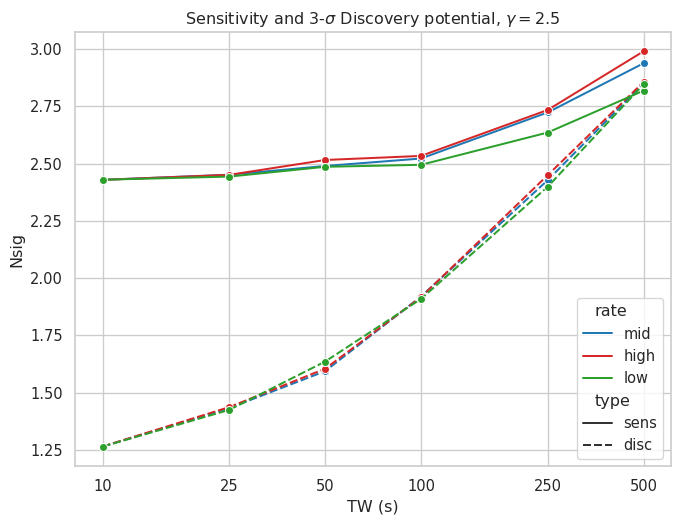

In [121]:
fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=96)

sns.lineplot(data=tw_sens_disc_number_long, x='tw', y='value', hue='rate', style='type', marker='o', ax=ax)

ax.set_xscale('log')
ax.set_xlabel("TW (s)")
ax.set_ylabel("Nsig")
ax.set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2.5$')
ax.set_xticks(tw_sens_disc['tw'])
ax.set_xticklabels(tw_sens_disc['tw'])

# plt.text(1e4, 3, 'IceCube Preliminary', color='r', fontsize=18)
plt.show()

In [130]:
def plot_sens_disc(grb_name='GRB180423A', use_first=100000):
    senss_dict = {}
    discs_dict = {}
    for variable in ['number', 'flux']:
        senss_dict[variable] = {}
        discs_dict[variable] = {}
        for variation in [None, 'high', 'low']:
            senss_dict[variable]['mid' if variation is None else variation] = []
            discs_dict[variable]['mid' if variation is None else variation] = []

    for variation in [None, 'high', 'low']:
        for tw in [10, 25, 50, 100, 250, 500]:
            ag = args(grb_name=grb_name,tw_in_second=tw)
            sens, disc = get_sens_disc(ag, sigma=3, fit=False, variation=variation, use_first=use_first)
            senss_dict['number']['mid' if variation is None else variation].append(sens['n_sig'])
            discs_dict['number']['mid' if variation is None else variation].append(disc['n_sig'])

            tr = get_tr(ag)

            senss_dict['flux']['mid' if variation is None else variation].append(tr.to_E2dNdE(sens['n_sig'], E0=1, unit=1e1))
            discs_dict['flux']['mid' if variation is None else variation].append(tr.to_E2dNdE(disc['n_sig'], E0=1, unit=1e1))
    
    tw_sens_disc_number = pd.DataFrame({'tw':[10, 25, 50, 100, 250, 500], 
                             'sens_mid': senss_dict['number']['mid'], 
                             'sens_high': senss_dict['number']['high'],
                             'sens_low': senss_dict['number']['low'],
                             'disc_mid': discs_dict['number']['mid'], 
                             'disc_high': discs_dict['number']['high'], 
                             'disc_low': discs_dict['number']['low']
                            })
    tw_sens_disc_number
    
    tw_sens_disc_number_long = pd.wide_to_long(tw_sens_disc_number, 
                                       stubnames=['sens', 'disc'], 
                                       i='tw',
                                       j='rate',
                                       sep='_', 
                                        suffix=r'\w+')
    tw_sens_disc_number_long.reset_index(level=None, inplace=True)
    tw_sens_disc_number_long = pd.melt(tw_sens_disc_number_long, id_vars=['tw','rate'], var_name='type')
    
    fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=96)

    sns.lineplot(data=tw_sens_disc_number_long, x='tw', y='value', hue='rate', style='type', marker='o', ax=ax)

    ax.set_xscale('log')
    ax.set_xlabel("TW (s)")
    ax.set_ylabel("Nsig")
    ax.set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2.5$')
    ax.set_xticks(tw_sens_disc['tw'])
    ax.set_xticklabels(tw_sens_disc['tw'])

    # plt.text(1e4, 3, 'IceCube Preliminary', color='r', fontsize=18)
    plt.show()

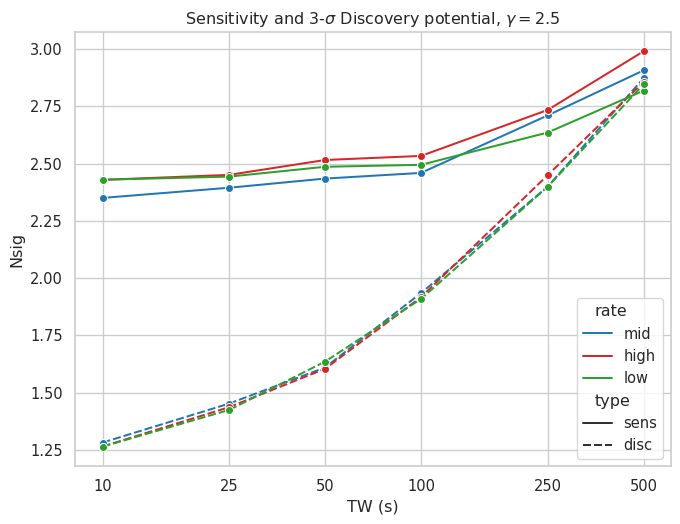

In [133]:
plot_sens_disc(grb_name='GRB180423A', use_first=1000000)

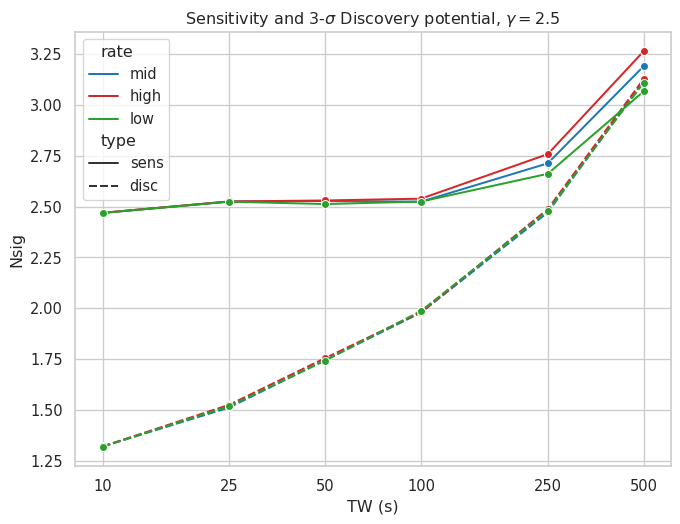

In [132]:
plot_sens_disc(grb_name='GRB150716A', use_first=100000)

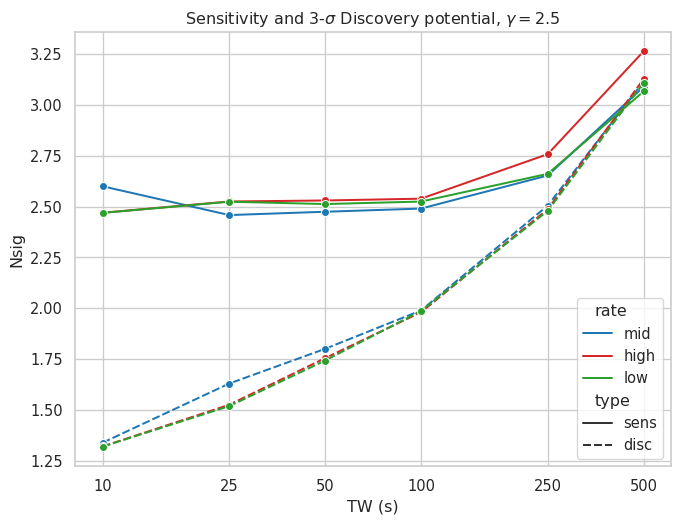

In [131]:
plot_sens_disc(grb_name='GRB150716A', use_first=1000000)